In [242]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

### Necessary functions

In [243]:
def clean_numeric(value):
    if pd.isna(value):
        return np.nan
    
    if isinstance(value, (int, float)):
        return value
    
    value = str(value).strip()
    
    if value.lower() in ['nan', 'null', '?', '', 'none', 'na', 'n/a', 'zero', 'empty', 'missing', '-', 'blank', '_', 'nothing']:
        return np.nan
    
    try:
        numeric_match = re.search(r'[-+]?\d*\.?\d+', value)
        if numeric_match:
            return float(numeric_match.group())
        else:
            return np.nan
    except:
        return np.nan


def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    if outliers > 0:
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

In [244]:
df = pd.read_csv('performance.csv')

In [245]:
df.info()
df.head()
df.describe()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2397 non-null   int64  
 1   Age                2397 non-null   int64  
 2   Gender             2397 non-null   int64  
 3   Ethnicity          2391 non-null   float64
 4   ParentalEducation  2397 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   object 
 6   Absences           2397 non-null   int64  
 7   Tutoring           2397 non-null   int64  
 8   ParentalSupport    2396 non-null   float64
 9   Extracurricular    2387 non-null   object 
 10  Sports             2397 non-null   int64  
 11  Music              2397 non-null   int64  
 12  Volunteering       2397 non-null   int64  
 13  GPA                2397 non-null   object 
 14  GradeClass         2397 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 281.0+ KB


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0.0,2,19.8337228078547,7,1,2.0,0,0,1,0,2.92919559166768,2
1,1002,18,0,0.0,1,15.4087560558467,0,0,1.0,0,0,0,0,3.04291483343638,1
2,1003,15,0,2.0,3,4.21056976881226,26,0,2.0,0,0,0,0,0.112602254466182,4
3,1004,17,1,0.0,3,10.0288294739582,14,0,3.0,1,0,0,0,2.05421813970295,3
4,1005,17,1,0.0,2,"""4.67249527297133""",17,1,3.0,0,0,0,0,1.28806118179539,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,3388,18,1,0.0,3,10.6805546076944,2,0,4.0,1,0,0,0,3.45550941103439,0
2393,3389,17,0,0.0,1,7.58321727959887,4,1,4.0,0,1,0,0,3.27914972702503,4
2394,3390,16,1,0.0,2,6.80549964468062,20,0,2.0,0,0,0,1,1.14233287952616,2
2395,3391,16,1,1.0,0,12.4166526554839,17,0,2.0,0,1,1,0,1.80329676262921,1


## Data Cleaning

In [246]:
cols_to_drop = ['StudentID','GradeClass']

all_cols = ['Age', 'StudyTimeWeekly', 'ParentalEducation', 'GPA', 'Tutoring', 'ParentalSupport', 'Extracurricular', "Sports", 'Gender', 'Ethnicity', 'Music', 'Volunteering', 'Absences']


### Dropping unnecessary columns

In [247]:
df = df.drop(columns=cols_to_drop)

### Removing Duplicate rows

In [248]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()

### Making numeric columns truly numeric

In [249]:
for col in all_cols:
    df[col] = df[col].apply(clean_numeric)

### Handling missing values

 - We will fill missing values in numeric columns with the mean of each column.

In [250]:
missing_values = df.isnull().sum()

numeric_imputer = SimpleImputer(strategy='mean')
df[all_cols] = numeric_imputer.fit_transform(df[all_cols])

### Removing outliers, using IQR method

In [251]:
# for col in ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']:
#     df = handle_outliers(df, col)
for col in all_cols:
    df = handle_outliers(df, col)

In [252]:
# Remove 

### Handling unrealistic combinations
1. Students with very low study time but very high GPA.
2. Students with very high study time but very low GPA.


In [253]:
unrealistic = ((df['StudyTimeWeekly'] < 1) & (df['GPA'] > 3.5)).sum()
if unrealistic > 0:
    mask = (df['StudyTimeWeekly'] < 1) & (df['GPA'] > 3.5)
    df.loc[mask, 'StudyTimeWeekly'] = df['StudyTimeWeekly'].median()

unrealistic = ((df['StudyTimeWeekly'] > 15) & (df['GPA'] < 2.0)).sum()
if unrealistic > 0:
    mask = (df['StudyTimeWeekly'] > 15) & (df['GPA'] < 2.0)
    df.loc[mask, 'StudyTimeWeekly'] = df['StudyTimeWeekly'].median()

### Handling negetive values

In [254]:
for col in  all_cols:
    neg_values = (df[col] < 0).sum()
    if neg_values > 0:
        df[col] = df[col].abs()

### Type conversion

In [255]:
for col in all_cols:
    df[col] = df[col].astype(float)

### Remove illegal values in categorical columns

In [256]:
target_columns = ['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

# Line 1: Create a boolean mask for valid rows across all specified columns
is_valid_row = df[target_columns].isin([0, 1]).all(axis=1)

# Line 2: Filter the DataFrame using the mask to keep only valid rows
df = df.loc[is_valid_row] 

In [257]:
X = df.drop(columns=['GPA'])
Y = df['GPA']

### Dataset

In [270]:
selected_cols = ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport']

for col in selected_cols:
    uniqueCol = df[col]
    print(f'{col}: {uniqueCol.unique()}\n')

min_max_summary = df[selected_cols].agg(['min', 'max'])

print(min_max_summary)


StudyTimeWeekly: [19.83372281 15.40875606  4.21056977 ...  6.80549964 12.41665266
 17.81990749]

Absences: [ 7.  0. 26. 14. 17. 10. 22. 15. 21.  9. 16. 29.  2. 20. 27. 23.  3. 12.
  1.  5. 13. 25. 11.  8.  6. 28.  4. 18. 19. 24.]

Tutoring: [1. 0.]

ParentalSupport: [2.         1.         3.         4.         0.         2.12212463]

     StudyTimeWeekly  Absences  Tutoring  ParentalSupport
min         0.001057       0.0       0.0              0.0
max        19.948459      29.0       1.0              4.0


# Feature Selection

## Corelation
### Measuring linear relation between a continuous feature and continuous target.

In [259]:
contenous_features = df[["Age", "StudyTimeWeekly", "Absences"]]
corr = contenous_features.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
upper

,Age,StudyTimeWeekly,Absences
Age,NaN,-0.012026,-0.011689
StudyTimeWeekly,NaN,NaN,-0.139913
Absences,NaN,NaN,NaN


### Spearman Correlation (For Ordinal Features)


- Used when predictors have ordered levels, but the relationship may not be linear.

- Works for continuous target.

ParentalEducation   -0.031298
ParentalSupport      0.173856
GPA                  1.000000
Name: GPA, dtype: float64


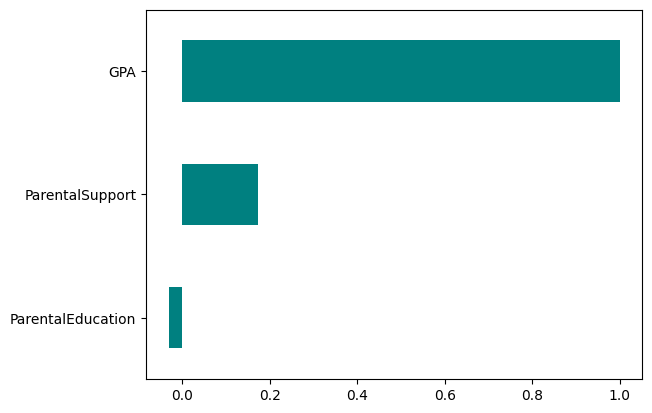

ParentalSupport Spearman: 0.1738562469527741 p-value: 1.3364510113577153e-17
ParentalEducation Spearman: -0.03129768228245088 p-value: 0.12698102534126052


In [260]:
sep_cols = ["ParentalEducation", "ParentalSupport", "GPA"]
spearman = df[sep_cols].corr(method='spearman')
print(spearman["GPA"])

pd.Series(spearman["GPA"]).plot(kind='barh', color='teal')
plt.show()


from scipy.stats import spearmanr

for col in ["ParentalSupport", "ParentalEducation"]:
    rho, p = spearmanr(df[col], df["GPA"])
    print(col, "Spearman:", rho, "p-value:", p)


### Mutual Information

- ```Can't use chi2 and ANOVA since the target is continuous.```

Age 0.014350111948761235
Gender 0.0
Ethnicity 0.0
ParentalEducation 0.005307690533937759
StudyTimeWeekly 0.1372979349994603
Absences 0.8785155516736864
Tutoring 0.026042504585419346
ParentalSupport 0.022198540832076397
Extracurricular 0.018196611256168005
Sports 0.0058355722600120785
Music 0.0
Volunteering 0.0


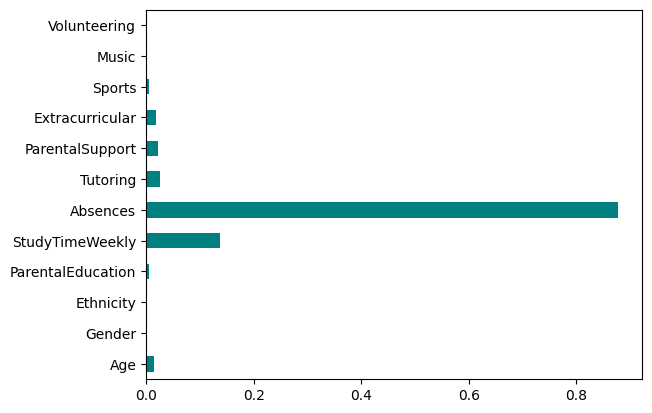

Selected features: ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport']


In [261]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X, Y)

for col, score in zip(X.columns, mi):
    print(col, score)

# Plot
pd.Series(mi, X.columns).plot(kind='barh', color='teal')
plt.show()

top_features = SelectKBest(score_func=mutual_info_regression, k=4)
top_features.fit(X, Y)
selected_features = X.columns[top_features.get_support()]
print("Selected features:", selected_features.tolist())


### Varience

#### Variance Threshold (Preprocessing Step)

- Removes features with too little variability, which cannot help prediction.

- Independent of target type.

- When useful? If any categorical variable has the same value for most students.

Age 1.2620235099717458
Gender 0.24983563445101906
Ethnicity 1.060350160818385
ParentalEducation 0.8974834269523457
StudyTimeWeekly 24.976760555640233
Absences 71.71796762374152
Tutoring 0.21105225578795547
ParentalSupport 1.2577320974456363
Extracurricular 0.2363937924684622
Sports 0.21105225578795547
Music 0.0
Volunteering 0.0


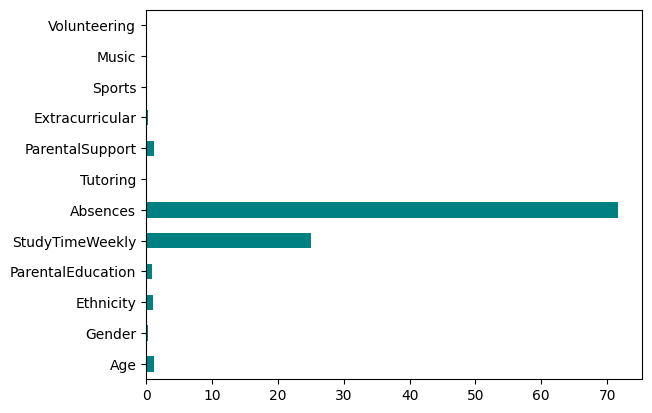

Features to remove: ['Absences', 'StudyTimeWeekly']


In [262]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.01)
vt.fit(X)

for col, score in zip(X.columns, vt.variances_):
    print(col, score)

pd.Series(vt.variances_, X.columns).plot(kind='barh', color='teal')
plt.show()

# Select 2 features to remove with sort and slice  
variances_series = pd.Series(vt.variances_, index=X.columns)
variances_sorted = variances_series.sort_values(ascending=False)
features_to_remove = variances_sorted.index[:2].tolist()
print("Features to remove:", features_to_remove) 

### Decision Tree Feature Importance

Age 0.005893265759695222
Gender 0.002607174980439857
Ethnicity 0.0058877612383271384
ParentalEducation 0.0077568078764394125
StudyTimeWeekly 0.06734754775524608
Absences 0.8458322649806086
Tutoring 0.013456116145622875
ParentalSupport 0.03266581090525235
Extracurricular 0.009561630032189891
Sports 0.00899162032617868
Music 0.0
Volunteering 0.0


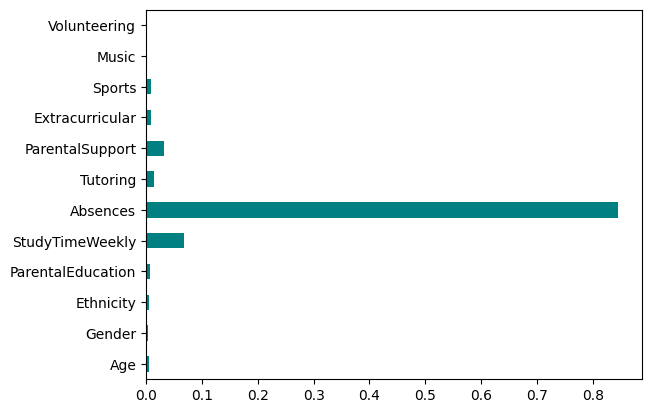

Top 4 features: ['Absences', 'StudyTimeWeekly', 'ParentalSupport', 'Tutoring']


In [263]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, Y)

for col, score in zip(X.columns, tree.feature_importances_):
    print(col, score)

pd.Series(tree.feature_importances_, X.columns).plot(kind='barh', color='teal')
plt.show()

# List top 3 features
importances_series = pd.Series(tree.feature_importances_, index=X.columns)
importances_sorted = importances_series.sort_values(ascending=False)
top_4_features = importances_sorted.index[:4].tolist()
print("Top 4 features:", top_4_features)

## RFE

#### Feature Selection (RFE - Random Forest)

In [264]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=4)
rfe.fit(X, Y)

for col, rank in zip(X.columns, rfe.ranking_):
    print(col, rank)

print("Selected features:", list(X.columns[rfe.support_]))

Age 5
Gender 7
Ethnicity 6
ParentalEducation 2
StudyTimeWeekly 1
Absences 1
Tutoring 1
ParentalSupport 1
Extracurricular 3
Sports 4
Music 9
Volunteering 8
Selected features: ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport']


### RFE with Linear Regression 
#### Finding Optimal number of features

In [265]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

model = LinearRegression()
cv = KFold(5)

rfecv = RFECV(estimator=model, cv=cv)
rfecv.fit(X, Y)

print("Optimal number of features:", rfecv.n_features_)
print("Selected Features:")

for col, support in zip(X.columns, rfecv.support_):
    print(col, support)


Optimal number of features: 7
Selected Features:
Age False
Gender True
Ethnicity False
ParentalEducation False
StudyTimeWeekly True
Absences True
Tutoring True
ParentalSupport True
Extracurricular True
Sports True
Music False
Volunteering False


#### Feature Selection (RFE - Linear Regression)

In [266]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model, n_features_to_select=4)
rfe.fit(X, Y)

for col, rank in zip(X.columns, rfe.ranking_):
    print(col, rank)

print("Selected features:", list(X.columns[rfe.support_]))

Age 6
Gender 4
Ethnicity 7
ParentalEducation 5
StudyTimeWeekly 3
Absences 2
Tutoring 1
ParentalSupport 1
Extracurricular 1
Sports 1
Music 9
Volunteering 8
Selected features: ['Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports']


In [267]:
# PCA for dimentionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target'] = Y
df_pca


,PC1,PC2,Target
0,-8.833020,9.846468,2.929196
1,-15.237020,4.573235,3.042915
2,11.953313,-3.301664,0.112602
3,-0.668743,0.989160,2.054218
4,2.966308,-3.946981,1.288061
...,...,...,...
2374,-12.658317,0.159512,1.067411
2375,-10.296543,-2.652050,0.569420
2376,5.681578,-1.470831,1.934762
2377,2.001366,3.732427,1.849104


## Regression

In [268]:
selected_features = ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport']

X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Model R² Score: {score*100:.2f}%")

# print(model.predict(X_test)[:100])


# Predict with new data
test_data = {
    "StudyTimeWeekly": 20,
    "Absences": 5,
    "Tutoring": 1,
    "ParentalSupport": 3,
}
new_df = pd.DataFrame([test_data])
new_df = new_df[selected_features]

prediction = model.predict(new_df)
print(f"\nPredicted GPA: {prediction[0]:.4f}")


Model R² Score: 92.27%

Predicted GPA: 3.4870


## Export Model 

In [269]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import joblib
import json


#Save selected feature names 
selected_features_list = list(selected_features)
with open("selected_features.json", "w") as f:
    json.dump(selected_features_list, f)

# Export model to ONNX
n_features = X_train.shape[1]

onnx_model = convert_sklearn(
    model,
    initial_types=[("input", FloatTensorType([None, n_features]))]
)

with open("student_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
